In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [2]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('test.csv')

## Setting up the image augmentation from last Lesson: 

In [3]:
IMG_SIZE = (224, 224)

In [4]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 6) ## We've only been provided with 6 validation images

Found 20 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.


In [5]:
## Pull a single large batch of random validation data for testing after each epoch
testX, testY = val_gen.next()

In [6]:
## Pull a single large batch of random validation data for testing after each epoch
testX, testY = val_gen.next()

In [7]:
## Pull a single large batch of random validation data for testing after each epoch
testX, testY = val_gen.next()

## Now we'll load in VGG16 with pre-trained ImageNet weights: 

In [8]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

Metal device set to: Apple M1


2022-03-14 11:36:30.151137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-14 11:36:30.151239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [10]:
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [11]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [12]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

In [13]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [14]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
## Run for 10 epochs to see if any learning occurs:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10


/var/folders/v_/rh4ycfcn3vd4r73j2nln2brm0000gn/T/ipykernel_59819/2430834703.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_gen,
2022-03-14 11:36:31.815448: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-14 11:36:32.027375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 320ms/step - loss: 1.3035 - binary_accuracy: 0.5500 - val_loss: 0.6880 - val_binary_accuracy: 0.6667


2022-03-14 11:36:32.886450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/10
3/3 [==============================] - 1s 187ms/step - loss: 1.2643 - binary_accuracy: 0.5500 - val_loss: 0.6872 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 1s 186ms/step - loss: 0.8595 - binary_accuracy: 0.4500 - val_loss: 0.6930 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 189ms/step - loss: 1.1139 - binary_accuracy: 0.6000 - val_loss: 0.6880 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 272ms/step - loss: 0.7920 - binary_accuracy: 0.8500 - val_loss: 0.6716 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 1s 269ms/step - loss: 0.8587 - binary_accuracy: 0.6000 - val_loss: 0.6611 - val_binary_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 1s 211ms/step - loss: 0.5503 - binary_accuracy: 0.7000 - val_loss: 0.6590 - val_binary_accuracy: 0.6667
Epoch 8/10
3/3 [==============================] - 1s 209ms/step - loss: 0.52

In [16]:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

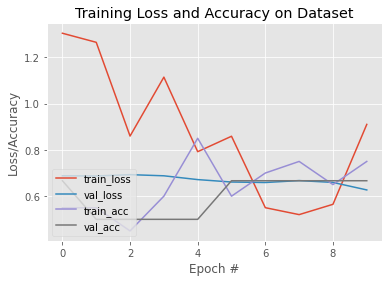

In [17]:
plot_history(history)

Based on the plot above, it looks like our model stopped learning after 7 epochs. You can tell this by looking at the decline in val_loss from epochs 0-7. 

## Try a model with less dropout, same learning rate: 

In [18]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.3))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.3))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [19]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

/var/folders/v_/rh4ycfcn3vd4r73j2nln2brm0000gn/T/ipykernel_59819/3038495923.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_gen,


Epoch 1/10


2022-03-14 11:36:39.690533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 321ms/step - loss: 0.8688 - binary_accuracy: 0.5500 - val_loss: 0.7080 - val_binary_accuracy: 0.5000


2022-03-14 11:36:40.454650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/10
3/3 [==============================] - 1s 210ms/step - loss: 0.6325 - binary_accuracy: 0.6000 - val_loss: 0.6660 - val_binary_accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 1s 215ms/step - loss: 0.6344 - binary_accuracy: 0.7000 - val_loss: 0.6280 - val_binary_accuracy: 0.6667
Epoch 4/10
3/3 [==============================] - 1s 191ms/step - loss: 0.5619 - binary_accuracy: 0.6000 - val_loss: 0.5505 - val_binary_accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 1s 211ms/step - loss: 0.7949 - binary_accuracy: 0.8000 - val_loss: 0.6364 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 1s 214ms/step - loss: 0.4453 - binary_accuracy: 0.7500 - val_loss: 0.5246 - val_binary_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 1s 299ms/step - loss: 0.3458 - binary_accuracy: 0.9000 - val_loss: 0.7128 - val_binary_accuracy: 0.6667
Epoch 8/10
3/3 [==============================] - 1s 284ms/step - loss: 0.42

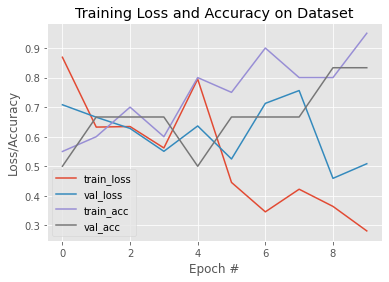

In [21]:
plot_history(history)

With less dropout, it looks like the model got worse since the train_loss dropped dramatically but the val_loss increased.

## Finally, try a model with the same amount of dropout as you initiall had, but a slower learning rate: 

In [22]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [23]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [24]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [25]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

/var/folders/v_/rh4ycfcn3vd4r73j2nln2brm0000gn/T/ipykernel_59819/3038495923.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_gen,


Epoch 1/10


2022-03-14 11:36:47.508100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 279ms/step - loss: 0.8102 - binary_accuracy: 0.3500 - val_loss: 0.6799 - val_binary_accuracy: 0.5000


2022-03-14 11:36:48.299509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/10
3/3 [==============================] - 1s 212ms/step - loss: 0.7482 - binary_accuracy: 0.5500 - val_loss: 0.6799 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 1s 188ms/step - loss: 0.6650 - binary_accuracy: 0.5500 - val_loss: 0.6797 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 276ms/step - loss: 0.6383 - binary_accuracy: 0.6000 - val_loss: 0.6794 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 209ms/step - loss: 0.7056 - binary_accuracy: 0.5000 - val_loss: 0.6792 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 1s 270ms/step - loss: 0.6980 - binary_accuracy: 0.6500 - val_loss: 0.6790 - val_binary_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 1s 209ms/step - loss: 0.7568 - binary_accuracy: 0.5500 - val_loss: 0.6788 - val_binary_accuracy: 0.5000
Epoch 8/10
3/3 [==============================] - 1s 273ms/step - loss: 0.68

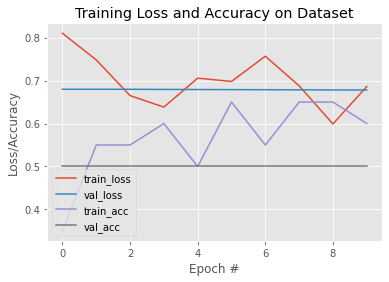

In [26]:
plot_history(history)

The performance with this architecture and parameters is pretty unstable, and also isn't learning based on the flat val_loss curve. We see, however, that between epoch 3 and 8 the train_loss goes down, which indicates that while the model was learning _something,_ it was essentially just learning to overfit on the training data. 